# 0 Imports

In [0]:
# install image toolkit
!pip install Pillow

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b07a5574-52e0-4c74-848e-f7f4434a0283/bin/python -m pip install --upgrade pip' command.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when,length,sum,avg,max,count,round
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter


from pyspark.sql.functions import udf, lit, col
from pyspark.sql.types import BinaryType, ArrayType, IntegerType
import numpy as np
from pyspark.ml.linalg import Vectors, VectorUDT
import pandas as pd


import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType

import io
from pyspark.ml.linalg import Vectors, VectorUDT

# 1 Import Images

In [0]:
spark = SparkSession.builder\
        .master("local")\
        .appName("eye_diseases_calssification")\
        .config("spark.driver.memory", "8g") \
        .getOrCreate()

In [0]:
# mount s3 bucket
access_key = ""
secret_key = ""
encoded_secret_key = secret_key.replace("/", "%2F")
aws_bucket_name = "ban5600"
mount_name = "dataset"

# dbutils.fs.mount("s3a://%s:%s@%s" % (access_key, encoded_secret_key, aws_bucket_name), "/mnt/%s" % mount_name)
display(dbutils.fs.ls("/mnt/%s" % mount_name))

path,name,size,modificationTime
dbfs:/mnt/dataset/dataset/,dataset/,0,0


In [0]:
df = spark.read.format('image').option('dropInvalid', True) \
    .option("recursiveFileLookup","true").load("/mnt/%s" % mount_name)

In [0]:
# add label for images
label = when(col('image.origin').contains('cataract'), 'cataract')\
.when(col('image.origin').contains('diabetic_retinopathy'), 'diabetic_retinopathy')\
.when(col('image.origin').contains('glaucoma'), 'glaucoma')\
.otherwise('normal')

df = df.withColumn('type', label)

# 2 Discriptive & Visualization

## 2.1 Summary

In [0]:
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- type: string (nullable = false)



In [0]:
df.count()

Out[102]: 2977

In [0]:
df.select('type', 'image.origin', 'image.width', 'image.height', 'image.nChannels', 'image.mode').show(10, truncate=False)

+--------+---------------------------------------------------+-----+------+---------+----+
|type    |origin                                             |width|height|nChannels|mode|
+--------+---------------------------------------------------+-----+------+---------+----+
|cataract|dbfs:/mnt/dataset/dataset/cataract/cataract_024.png|2464 |1632  |3        |16  |
|glaucoma|dbfs:/mnt/dataset/dataset/glaucoma/Glaucoma_081.png|2464 |1632  |3        |16  |
|glaucoma|dbfs:/mnt/dataset/dataset/glaucoma/Glaucoma_072.png|2464 |1632  |3        |16  |
|glaucoma|dbfs:/mnt/dataset/dataset/glaucoma/Glaucoma_024.png|2464 |1632  |3        |16  |
|glaucoma|dbfs:/mnt/dataset/dataset/glaucoma/Glaucoma_071.png|2464 |1632  |3        |16  |
|glaucoma|dbfs:/mnt/dataset/dataset/glaucoma/Glaucoma_082.png|2464 |1632  |3        |16  |
|glaucoma|dbfs:/mnt/dataset/dataset/glaucoma/Glaucoma_048.png|2464 |1632  |3        |16  |
|cataract|dbfs:/mnt/dataset/dataset/cataract/cataract_074.png|2464 |1632  |3        |16  |

In [0]:
# Summary of categorical and numerical fileds
summary_df = df.select('type','image.width', 'image.height', 'image.nChannels', 'image.mode').cache()
summary_df.summary().show()

+-------+--------+------------------+------------------+---------+----+
|summary|    type|             width|            height|nChannels|mode|
+-------+--------+------------------+------------------+---------+----+
|  count|    2977|              2977|              2977|     2977|2977|
|   mean|    null| 648.1746724890829|  591.086328518643|      3.0|16.0|
| stddev|    null|507.94338819232763|295.39371099230834|      0.0| 0.0|
|    min|cataract|               512|               512|        3|  16|
|    25%|    null|               512|               512|        3|  16|
|    50%|    null|               512|               512|        3|  16|
|    75%|    null|               512|               512|        3|  16|
|    max|  normal|              2592|              1728|        3|  16|
+-------+--------+------------------+------------------+---------+----+



### 2.1.1 Count dictinct values

In [0]:
summary_df.groupby('type').count().show()

+--------------------+-----+
|                type|count|
+--------------------+-----+
|            cataract|  398|
|            glaucoma|  407|
|              normal| 1074|
|diabetic_retinopathy| 1098|
+--------------------+-----+



In [0]:
summary_df.groupby('width').count().show()

+-----+-----+
|width|count|
+-----+-----+
| 2464|   41|
| 2592|  150|
| 1848|   10|
|  512| 2776|
+-----+-----+



In [0]:
summary_df.groupby('height').count().show()

+------+-----+
|height|count|
+------+-----+
|  1632|   41|
|  1728|  150|
|   512| 2776|
|  1224|   10|
+------+-----+



In [0]:
summary_df.groupby('nChannels').count().show()

+---------+-----+
|nChannels|count|
+---------+-----+
|        3| 2977|
+---------+-----+



In [0]:
summary_df.groupby('mode').count().show()

+----+-----+
|mode|count|
+----+-----+
|  16| 2977|
+----+-----+



## 2.2 Visualization

In [0]:
# To visualize dataset with seaborn, change pyspark dataframe to pandas dataframe
pandasdf = summary_df.toPandas()

In [0]:
pandasdf.head()

,type,width,height,nChannels,mode
0,cataract,2464,1632,3,16
1,glaucoma,2464,1632,3,16
2,glaucoma,2464,1632,3,16
3,glaucoma,2464,1632,3,16
4,glaucoma,2464,1632,3,16


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

### 2.2.1 The proportion of different image type

Out[19]: <AxesSubplot:title={'center':'The pie chart of different image type'}>

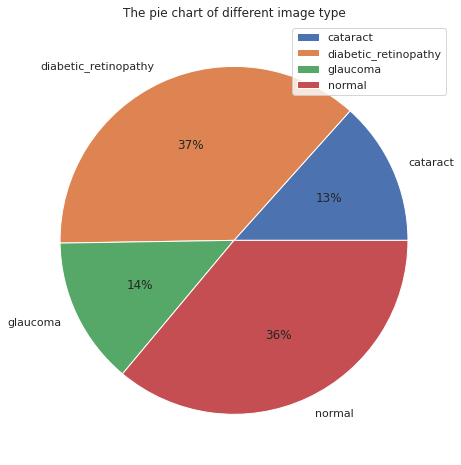

In [0]:
pandasdf.groupby(['type']).count().plot.pie(y='width', autopct='%1.0f%%', ylabel='',
                                            title = 'The pie chart of different image type',figsize=(8, 8))

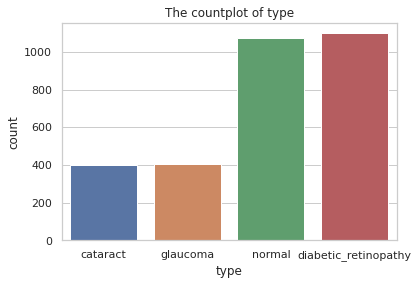

In [0]:
ax = sns.countplot(x=pandasdf.type).set(title='The countplot of type')
plt.show()

#### The distribution of images' width

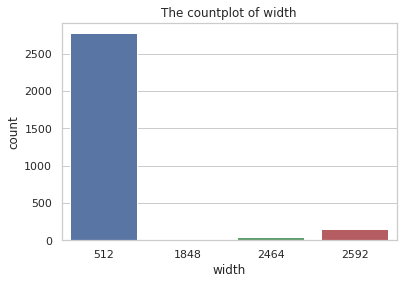

In [0]:
ax = sns.countplot(x=pandasdf.width).set(title='The countplot of width')
plt.show()

#### The distribution of images' height

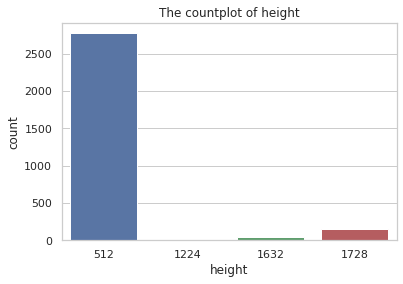

In [0]:
ax = sns.countplot(x=pandasdf.height).set(title='The countplot of height')
plt.show()

# 3 Data Preparation

In [0]:
from pyspark.ml.feature import StringIndexer, VectorIndexer

- Remove images that has invalid shap (the ratio is not equal to 1:1)

In [0]:
df = df.repartition(2).filter((df['image.height'] == 512) & (df['image.width'] == 512) )

In [0]:
def resize(image):
    pil_img = Image.frombytes('RGB', (512, 512), bytes(image)).resize((64, 64))
    return bytearray(pil_img.tobytes())

# Resize image (64 * 64) to reduce size
resize_udf = udf(lambda x:resize(x), BinaryType())

resized_df = df.repartition(2).select('type', resize_udf('image.data').alias('imagedata')).cache()

In [0]:
resized_df.count()

Out[145]: 2776

In [0]:
# Add numerical label
labelIndexer = StringIndexer(inputCol="type", outputCol="indexedType").fit(resized_df)

resized_df = labelIndexer.transform(resized_df)


# 4 Feature Transform

In [0]:
# pick a small sample as target
sample = resized_df.sample(fraction=0.2, seed=100).cache()
# sample = resized_df

## 4.1 Image Transform helper

In [0]:
class ImageTransformer:
    
    def __init__(self, image_content, width=64, height=64):
        self.content = image_content
        self.width = width
        self.height = height

    def to_pillow(self):
        return Image.frombytes('RGB', (self.width, self.height), bytes(self.content))
        
    # Grayscale image (transfer images from three layers to one layer)
    def to_grayscale(self):
        img_obj = self.to_pillow()
        img_obj = ImageOps.grayscale(img_obj)
        return img_obj

    # Find edges
    def find_edges(self):
        img_obj = self.to_pillow()
        img_obj =  img_obj.convert("L").filter(ImageFilter.FIND_EDGES)
        return img_obj

    #  Binarize Images Calulating an average 
    def binarize(self):
        img_obj = self.to_pillow()
        img_obj = img_obj.convert("L")
        for x in range(64):
            for y in range(64):
                if img_obj.getpixel((x,y)) < 50:
                    img_obj.putpixel((x,y),0)
                else:
                    img_obj.putpixel((x,y),255)
        return img_obj


- compare orign image, gray image, and edge image

In [0]:
first_img = sample.first()

In [0]:
first_img['type']

Out[150]: 'normal'

In [0]:
first_img_tansf = ImageTransformer(first_img['imagedata'])

- Original image

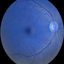

In [0]:
first_img_tansf.to_pillow()

- Grayscale Image

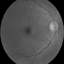

In [0]:
first_img_tansf.to_grayscale()

- Images with only edges

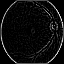

In [0]:
first_img_tansf.find_edges()

- Binarized Image

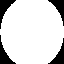

In [0]:
first_img_tansf.binarize()

## 5 Traning Models

## 5.1 Feature Selection Helper

In [0]:
model = ResNet50(include_top=False)
model.summary()  # verify that the top layer is removed

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [0]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model


def preprocess(content, image_func):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = image_func(content)
    arr = img_to_array(img)
    #   print(arr.shape)
    return preprocess_input(arr)

def featurize_series(model, content_series, image_func):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    def wrapper(content):
        return preprocess(content, image_func)
    
    input = np.stack(content_series.map(wrapper))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series, image_func)
        
        
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def orginal_udf(content_series_iter):
    model = model_fn()
    
    image_func = lambda content: ImageTransformer(content).to_pillow()
    
    for content_series in content_series_iter:
        yield featurize_series(model, content_series, image_func)

        
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def grayscale_udf(content_series_iter):
    model = model_fn()
    
    image_func = lambda content: ImageTransformer(content).to_grayscale().convert("RGB")
    
    for content_series in content_series_iter:
        yield featurize_series(model, content_series, image_func)
        
        
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def edge_udf(content_series_iter):
    model = model_fn()
    
    image_func = lambda content: ImageTransformer(content).find_edges().convert("RGB")
    
    for content_series in content_series_iter:
        yield featurize_series(model, content_series, image_func)
        
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def binarize_udf(content_series_iter):
    model = model_fn()
    
    image_func = lambda content: ImageTransformer(content).binarize().convert("RGB")
    
    for content_series in content_series_iter:
        yield featurize_series(model, content_series, image_func)


## 5.2 Training

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier,LogisticRegression,GBTClassifier,RandomForestClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.functions import array_to_vector

In [0]:
def split_dataframe(dataframe):
    return dataframe.randomSplit([0.7, 0.3], 100)

def train_decisiontree(training, test):
    dt = DecisionTreeClassifier(labelCol="indexedType", featuresCol="features")
    dtmodel = dt.fit(training)
    # Make predictions.
    dtpredictions = dtmodel.transform(test)
    # reduce df size 
    dtpredictions.drop('features')
    show_summary(dtpredictions, 'Decision Tree')
    return dtmodel, dtpredictions

def train_logisticregression(training, test):
    lr = LogisticRegression(maxIter=5, labelCol="indexedType", featuresCol="features")

    # Fit the model
    lrModel = lr.fit(training)
    # Make predictions.
    lrpredictions = lrModel.transform(test)
    # reduce df size    
    lrpredictions.drop('features')
    show_summary(lrpredictions, 'LogisticRegression')
    
    return lrModel, lrpredictions

def train_randomforest(training, test):
    # Train a GBT model.
    rf = RandomForestClassifier(labelCol="indexedType", featuresCol="features", numTrees=10)

    # Train model.  This also runs the indexers.
    rfmodel = rf.fit(training)

    # Make predictions.
    rftpredictions = rfmodel.transform(test)
    # reduce df size 
    rftpredictions.drop('features')
    show_summary(rftpredictions, 'RandomForestClassifier')
    return rfmodel, rftpredictions

def show_summary(prediction, model_name):
    print('Summary of {}'.format(model_name))
    rdd = prediction.select('indexedType', 'prediction').rdd
    metrics = MulticlassMetrics(rdd)
    
    print(metrics.confusionMatrix().toArray())

    print('falsePositiveRate is {}'.format(metrics.falsePositiveRate(0.0)))
    print('precision is {}'.format(metrics.precision(0.0)))
    print('recall is {}'.format(metrics.recall(0.0)))
#     print('fMeasure is {}'.format(metrics.fMeasure(0.0, 2.0)))
    print('accuracy is {}'.format(metrics.accuracy))
    print('weightedFalsePositiveRate is {}'.format(metrics.weightedFalsePositiveRate))
    print('weightedPrecision is {}'.format(metrics.weightedPrecision))
    print('weightedRecall is {}'.format(metrics.weightedRecall))
    print('weightedFMeasure is {}'.format(metrics.weightedFMeasure()))
    print('weightedFMeasure is {}'.format(metrics.weightedFMeasure(0.0)))

### 5.2.1 Original Image

In [0]:
features_df = sample.select("type", orginal_udf("imagedata").alias("features"), 'indexedType').cache()

features_df = features_df.withColumn('features', array_to_vector('features'))

In [0]:
features_df.show(5)

+--------------------+--------------------+-----------+
|                type|            features|indexedType|
+--------------------+--------------------+-----------+
|              normal|[0.0,2.3112723827...|        1.0|
|diabetic_retinopathy|[0.0,2.8462824821...|        0.0|
|              normal|[0.0,0.0,0.0,0.0,...|        1.0|
|              normal|[0.0,0.0,0.0,0.0,...|        1.0|
|              normal|[0.0,0.0,0.0,0.0,...|        1.0|
+--------------------+--------------------+-----------+
only showing top 5 rows



In [0]:
(trainingData, testData) = split_dataframe(features_df)

In [0]:
# DecisionTree
train_decisiontree(trainingData, testData)

Summary of Decision Tree
[[39.  5.  3.  0.]
 [19. 49. 18.  9.]
 [ 2. 10.  3.  0.]
 [ 4.  4.  2.  6.]]
falsePositiveRate is 0.1984126984126984
precision is 0.609375
recall is 0.8297872340425532
accuracy is 0.5606936416184971
weightedFalsePositiveRate is 0.2055905446384349
weightedPrecision is 0.6082501536630659
weightedRecall is 0.5606936416184971
weightedFMeasure is 0.5695506461417412
weightedFMeasure is 0.6082501536630659
Out[163]: (DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2a5ed0d06b12, depth=5, numNodes=45, numClasses=4, numFeatures=8192,
 DataFrame[type: string, features: vector, indexedType: double, rawPrediction: vector, probability: vector, prediction: double])

In [0]:
train_logisticregression(trainingData, testData)

Summary of LogisticRegression
[[53.  4.  2.  0.]
 [ 5. 56. 16.  7.]
 [ 3.  3.  6.  1.]
 [ 3.  5.  2.  7.]]
falsePositiveRate is 0.09649122807017543
precision is 0.828125
recall is 0.8983050847457628
accuracy is 0.7052023121387283
weightedFalsePositiveRate is 0.11280705216511233
weightedPrecision is 0.7454865833616683
weightedRecall is 0.7052023121387283
weightedFMeasure is 0.7177905508519642
weightedFMeasure is 0.7454865833616683
Out[164]: (LogisticRegressionModel: uid=LogisticRegression_fee3b9c8b663, numClasses=4, numFeatures=8192,
 DataFrame[type: string, features: vector, indexedType: double, rawPrediction: vector, probability: vector, prediction: double])

In [0]:
train_randomforest(trainingData, testData)

Summary of RandomForestClassifier
[[40.  1.  4.  0.]
 [23. 63. 20. 13.]
 [ 1.  0.  1.  0.]
 [ 0.  4.  1.  2.]]
falsePositiveRate is 0.1875
precision is 0.625
recall is 0.8888888888888888
accuracy is 0.6127167630057804
weightedFalsePositiveRate is 0.11732143901977785
weightedPrecision is 0.8056951237587076
weightedRecall is 0.6127167630057804
weightedFMeasure is 0.6625718238912278
weightedFMeasure is 0.8056951237587076
Out[165]: (RandomForestClassificationModel: uid=RandomForestClassifier_9a78494b4063, numTrees=10, numClasses=4, numFeatures=8192,
 DataFrame[type: string, features: vector, indexedType: double, rawPrediction: vector, probability: vector, prediction: double])

## 5.2.2 Grayscale

In [0]:
gray_features_df = sample.select("type", grayscale_udf("imagedata").alias("features"), 'indexedType').cache()

gray_features_df = gray_features_df.withColumn('features', array_to_vector('features'))

In [0]:
gray_features_df.show(5)

+--------------------+--------------------+-----------+
|                type|            features|indexedType|
+--------------------+--------------------+-----------+
|              normal|[0.0,0.1971921920...|        1.0|
|diabetic_retinopathy|[0.0,1.2932217121...|        0.0|
|              normal|[0.0,0.0,0.0,0.0,...|        1.0|
|              normal|[1.16258323192596...|        1.0|
|              normal|[0.0,0.0,0.0,0.0,...|        1.0|
+--------------------+--------------------+-----------+
only showing top 5 rows



In [0]:
(gray_trainingData, gray_testData) = split_dataframe(gray_features_df)

In [0]:
train_decisiontree(gray_trainingData, gray_testData)

Summary of Decision Tree
[[41.  9.  3.  2.]
 [19. 44. 17.  9.]
 [ 4. 14.  6.  2.]
 [ 0.  1.  0.  2.]]
falsePositiveRate is 0.19491525423728814
precision is 0.640625
recall is 0.7454545454545455
accuracy is 0.5375722543352601
weightedFalsePositiveRate is 0.23072680429083553
weightedPrecision is 0.573541099965998
weightedRecall is 0.5375722543352601
weightedFMeasure is 0.5459605586647605
weightedFMeasure is 0.573541099965998
Out[169]: (DecisionTreeClassificationModel: uid=DecisionTreeClassifier_13a7e4f54ca4, depth=5, numNodes=39, numClasses=4, numFeatures=8192,
 DataFrame[type: string, features: vector, indexedType: double, rawPrediction: vector, probability: vector, prediction: double])

In [0]:
train_logisticregression(gray_trainingData, gray_testData)

Summary of LogisticRegression
[[53.  8.  1.  0.]
 [ 6. 56. 16.  2.]
 [ 3.  2.  7.  1.]
 [ 2.  2.  2. 12.]]
falsePositiveRate is 0.0990990990990991
precision is 0.828125
recall is 0.8548387096774194
accuracy is 0.7398843930635838
weightedFalsePositiveRate is 0.10612058893687647
weightedPrecision is 0.7810757395443726
weightedRecall is 0.7398843930635838
weightedFMeasure is 0.7540858176696326
weightedFMeasure is 0.7810757395443726
Out[170]: (LogisticRegressionModel: uid=LogisticRegression_d56ee3e2f90e, numClasses=4, numFeatures=8192,
 DataFrame[type: string, features: vector, indexedType: double, rawPrediction: vector, probability: vector, prediction: double])

In [0]:
train_randomforest(gray_trainingData, gray_testData)

Summary of RandomForestClassifier
[[45.  5.  4.  1.]
 [18. 60. 18.  4.]
 [ 0.  0.  2.  2.]
 [ 1.  3.  2.  8.]]
falsePositiveRate is 0.16101694915254236
precision is 0.703125
recall is 0.8181818181818182
accuracy is 0.6647398843930635
weightedFalsePositiveRate is 0.1213828661937274
weightedPrecision is 0.7785059427283586
weightedRecall is 0.6647398843930635
weightedFMeasure is 0.7010559615514534
weightedFMeasure is 0.7785059427283587
Out[171]: (RandomForestClassificationModel: uid=RandomForestClassifier_04fed44969a7, numTrees=10, numClasses=4, numFeatures=8192,
 DataFrame[type: string, features: vector, indexedType: double, rawPrediction: vector, probability: vector, prediction: double])

### 5.2.3 Edges

In [0]:
edge_features_df = sample.select("type", edge_udf("imagedata").alias("features"), 'indexedType').cache()

edge_features_df = edge_features_df.withColumn('features', array_to_vector('features'))

In [0]:
edge_features_df.show(5)

+--------------------+--------------------+-----------+
|                type|            features|indexedType|
+--------------------+--------------------+-----------+
|              normal|[0.0,0.0,0.0,0.0,...|        1.0|
|diabetic_retinopathy|[0.0,0.0,0.0,0.59...|        0.0|
|              normal|[0.0,0.0,2.066812...|        1.0|
|              normal|[0.0,0.0,0.787149...|        1.0|
|              normal|[0.69357669353485...|        1.0|
+--------------------+--------------------+-----------+
only showing top 5 rows



In [0]:
(edge_trainingData, edge_testData) = split_dataframe(edge_features_df)

In [0]:
train_decisiontree(edge_trainingData, edge_testData)

Summary of Decision Tree
[[47.  1.  1.  0.]
 [14. 62. 16.  5.]
 [ 3.  4.  4.  3.]
 [ 0.  1.  5.  7.]]
falsePositiveRate is 0.13709677419354838
precision is 0.734375
recall is 0.9591836734693877
accuracy is 0.6936416184971098
weightedFalsePositiveRate is 0.09805054098592467
weightedPrecision is 0.7667402560179251
weightedRecall is 0.6936416184971097
weightedFMeasure is 0.7107400673056204
weightedFMeasure is 0.7667402560179251
Out[175]: (DecisionTreeClassificationModel: uid=DecisionTreeClassifier_13486cf65501, depth=5, numNodes=27, numClasses=4, numFeatures=8192,
 DataFrame[type: string, features: vector, indexedType: double, rawPrediction: vector, probability: vector, prediction: double])

In [0]:
train_logisticregression(edge_trainingData, edge_testData)

Summary of LogisticRegression
[[52.  0.  2.  0.]
 [ 8. 62. 17.  4.]
 [ 1.  3.  2.  1.]
 [ 3.  3.  5. 10.]]
falsePositiveRate is 0.10084033613445378
precision is 0.8125
recall is 0.9629629629629629
accuracy is 0.7283236994219653
weightedFalsePositiveRate is 0.07980781735885348
weightedPrecision is 0.817248842622865
weightedRecall is 0.7283236994219653
weightedFMeasure is 0.7576700885159194
weightedFMeasure is 0.817248842622865
Out[176]: (LogisticRegressionModel: uid=LogisticRegression_e9d43a724e05, numClasses=4, numFeatures=8192,
 DataFrame[type: string, features: vector, indexedType: double, rawPrediction: vector, probability: vector, prediction: double])

In [0]:
train_randomforest(edge_trainingData, edge_testData)

Summary of RandomForestClassifier
[[54.  3.  4.  0.]
 [10. 65. 17.  4.]
 [ 0.  0.  3.  1.]
 [ 0.  0.  2. 10.]]
falsePositiveRate is 0.08928571428571429
precision is 0.84375
recall is 0.8852459016393442
accuracy is 0.7630057803468208
weightedFalsePositiveRate is 0.058403108770905085
weightedPrecision is 0.8768496782883897
weightedRecall is 0.7630057803468209
weightedFMeasure is 0.8005228315866975
weightedFMeasure is 0.8768496782883897
Out[177]: (RandomForestClassificationModel: uid=RandomForestClassifier_61392faa892c, numTrees=10, numClasses=4, numFeatures=8192,
 DataFrame[type: string, features: vector, indexedType: double, rawPrediction: vector, probability: vector, prediction: double])